Principal Component Analysis is used for dimension reduction of high-dimensional data. We also refer PCA as feature extraction technique, where new features take the linear combinations from original features.

More on PCA : <a href="https://sijanb.com.np/posts/principal-component-analysis-pca-for-visualization-using-python/">principal-component-analysis-pca-for-visualization-using-python</a>


In this post, we will investigate 'how reliable the information is as preserved by PCA'. In order to do that, we will use labelled data and evaluate the trained model to see the final performance. (In side note, PCA is unsupervised learning algorithm. But, in our case, we are using in supervised fashion to assess the model performance)

To make it more interesting, we will also see Random Forests as 'feature selection' and compare the result with PCA.

### 1. PCA as Feature Extraction

In [39]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [40]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None, sep=',')

df.columns = ['CLASS', 'ALCOHOL_LEVEL', 'MALIC_ACID', 'ASH', 'ALCALINITY','MAGNESIUM', 'PHENOLS', 
              'FLAVANOIDS', 'NON_FLAVANOID_PHENOL', 'PROANTHOCYANINS', 'COLOR_INTENSITY', 
              'HUE', 'OD280/OD315_DILUTED','PROLINE']
df.head()

,CLASS,ALCOHOL_LEVEL,MALIC_ACID,ASH,ALCALINITY,MAGNESIUM,PHENOLS,FLAVANOIDS,NON_FLAVANOID_PHENOL,PROANTHOCYANINS,COLOR_INTENSITY,HUE,OD280/OD315_DILUTED,PROLINE
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [41]:
features = ['ALCOHOL_LEVEL', 'MALIC_ACID', 'ASH', 'ALCALINITY','MAGNESIUM', 'PHENOLS', 
              'FLAVANOIDS', 'NON_FLAVANOID_PHENOL', 'PROANTHOCYANINS', 'COLOR_INTENSITY', 
              'HUE', 'OD280/OD315_DILUTED','PROLINE']
label = 'CLASS'

X = df[features]
y = df[label]

# train test split with 70% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#### a. Preparing Projected data using PCA

In [42]:
# prepare correlation matrix
# standar scaler for normalization
N, _ = df.shape
scaler = StandardScaler()
Z = scaler.fit_transform(X)
# Correlation estimation
R = np.dot(Z.T, Z) / N

# eigendecomposition
eigen_values, eigen_vectors = np.linalg.eig(R)

# prepare projection matrix
value_idx = eigen_values.argsort()[::-1]
eigen_vectors_sorted = eigen_vectors[:, value_idx]

# Projection matrix with 3 PCs ( 3 PCs cover 65% variance in the data)
# more on : https://sijanb.com.np/posts/principal-component-analysis-pca-for-visualization-using-python/
M = np.hstack((eigen_vectors_sorted[0][:, np.newaxis],
               eigen_vectors_sorted[1][:, np.newaxis],
               eigen_vectors_sorted[2][:, np.newaxis]))

# projected data
projected_data = np.asmatrix(Z) * np.asmatrix(M)

#### b. Using Projected data for the training and prediction using Decision Tree

In [43]:
# train test split for training
Xpc_train, Xpc_test, ypc_train, ypc_test = train_test_split( projected_data, y, test_size=0.3, random_state=0)

tree_pca = DecisionTreeClassifier(max_depth=6, random_state=0)
tree_pca.fit(Z_pca_train, y_pca_train)

y_pca_pred = tree_pca.predict(Z_pca_test)
print('Test accuracy using Decision tree on PCA projected data: %.2f' % accuracy_score(y_pca_test, y_pca_pred))

Test accuracy using Decision tree on PCA projected data: 0.78


<!-- TEASER_END -->

### 2. Random Forest as Feature Selection

Random Forest is an ensemble learning of decision trees, where number of decision trees will give better generalization performance to the final model.


#### a. Training

We will be using the same Wine data as we used in our previous post. 

In [44]:
# Random Forests with 100 decision trees
# using parallized ( assign 2 cores for computation (n_jobs))
model = RandomForestClassifier(n_estimators=100, random_state=1,n_jobs=2)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [45]:

y_predictions = model.predict(X_test)
print('Test accuracy using Random Forests: %.2f' % accuracy_score(y_test, y_predictions))

Test accuracy using Random Forests: 0.96


#### b. Calculate Feature importance

Random Forest calculates the feature importance based on it's contribution to model accuracy. It simply assigns a value between 0 and 1 to each feature. Value near to 1 signifies it's higher contribution for model correct prediction.

In [46]:
feature_imp = pd.DataFrame({'feature': features,'importances': model.feature_importances_}).\
                    sort_values('importances', ascending = False)

feature_imp.head()


,feature,importances
9,COLOR_INTENSITY,0.164909
6,FLAVANOIDS,0.164451
12,PROLINE,0.158675
11,OD280/OD315_DILUTED,0.154081
0,ALCOHOL_LEVEL,0.115701


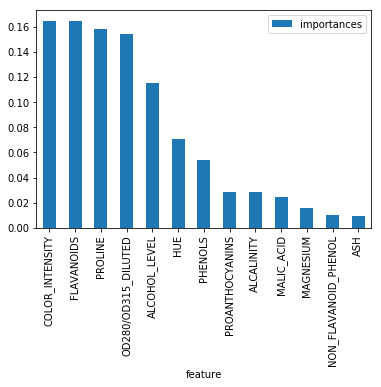

In [47]:
feature_imp.plot('feature', 'importances', kind='bar')

We can see that four features 'Color intensity', 'Flavanoids', 'Proline', and 'OD280/OD315_DILUTED' have higher importance and we can use them in order to classify different wines.

For the simplicity, we will use first three features ('Color intensity', 'Flavanoids', 'Proline') and use for our classification.


NOTE* : Since we are using 3 Principal components, we will use 3 features from Random Forests to build our new model.

#### c. Prepare Decision Tree model based on features selected by Random Forests

In [48]:
# select only two features for new data, that we will use for training/prediction
X_rf = X[['COLOR_INTENSITY', 'FLAVANOIDS', 'PROLINE']]

In [49]:
# train test split on X_rf

Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(X_rf, y, test_size=0.3, random_state=0)

# prepare decision tree model based on features selected by Random Forests
model_rf = DecisionTreeClassifier(max_depth=6, random_state=0)
model_rf.fit(Xrf_train, yrf_train)

yrf_prediction = model_rf.predict(Xrf_test)
print('Test accuracy using Decision tree on data based on Features by Random Forests: %.2f' % accuracy_score(yrf_test, yrf_prediction))


Test accuracy using Decision tree on data based on Features by Random Forests: 0.94


We train two different Decision Tree based on PCA projected data and important features given by Random Forests. We saw that the Test Accuracy by PCA based model is 78% whereas that based on Random Forests features is 94 %. The results are not much comparable but the goal here is to understand - 'PCA preserves the information'. I have used only 3 principal components (which covers only 65% variance in the data). We can add more principal components to get the comparable results.